C:\Users\Gašper Harej\AppData\Local\Temp\ipykernel_3036\3826438824.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm = np.sqrt(np.trapz(psi_mat[:,i]**2, x_int))
C:\Users\Gašper Harej\AppData\Local\Temp\ipykernel_3036\3826438824.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi /= np.sqrt(np.trapz(psi**2, x))


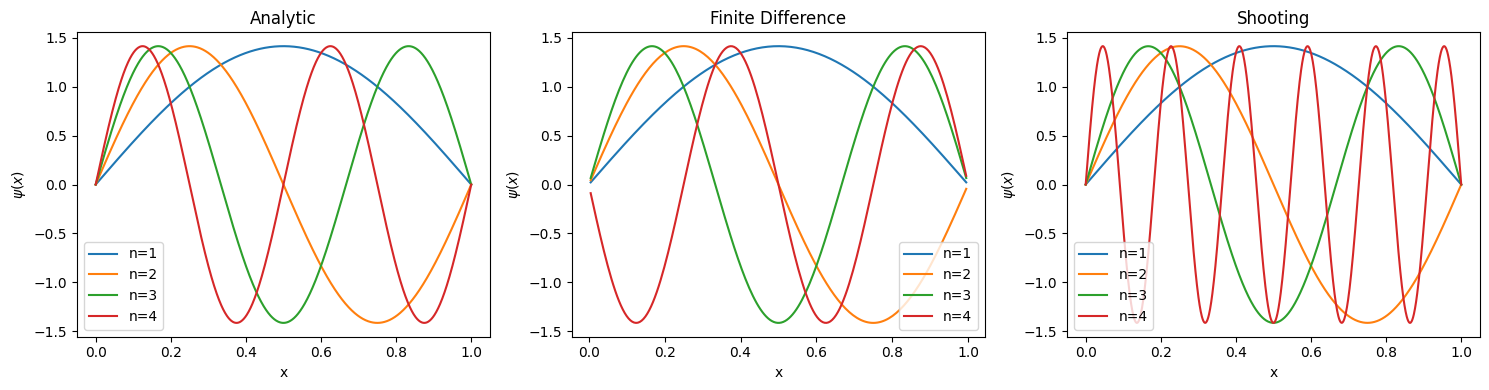

C:\Users\Gašper Harej\AppData\Local\Temp\ipykernel_3036\3826438824.py:121: RuntimeWarning: invalid value encountered in divide
  rel_err_sh = abs_err_sh / np.abs(psi1_an_sh)
C:\Users\Gašper Harej\AppData\Local\Temp\ipykernel_3036\3826438824.py:122: RuntimeWarning: divide by zero encountered in log
  log_err_sh = np.log(abs_err_sh)


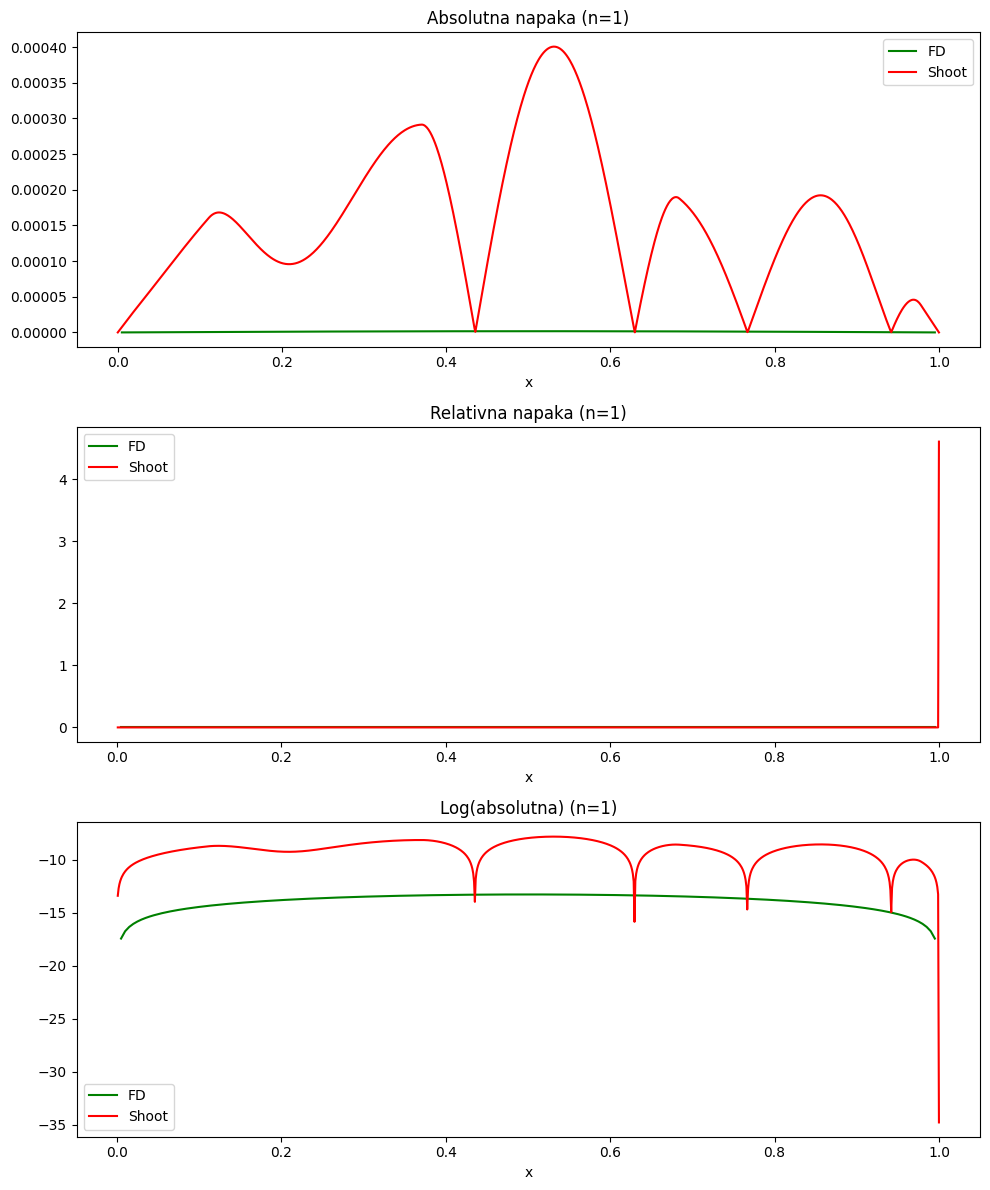

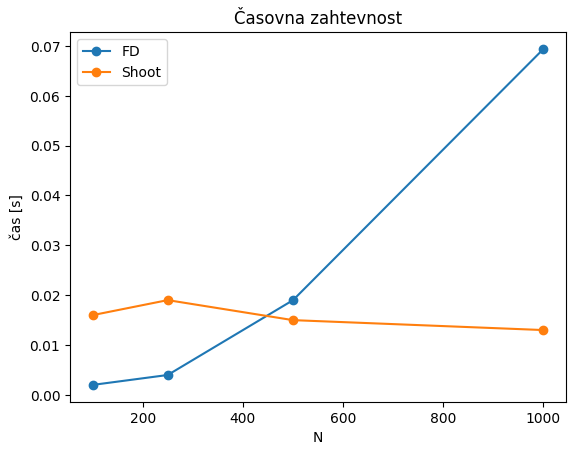

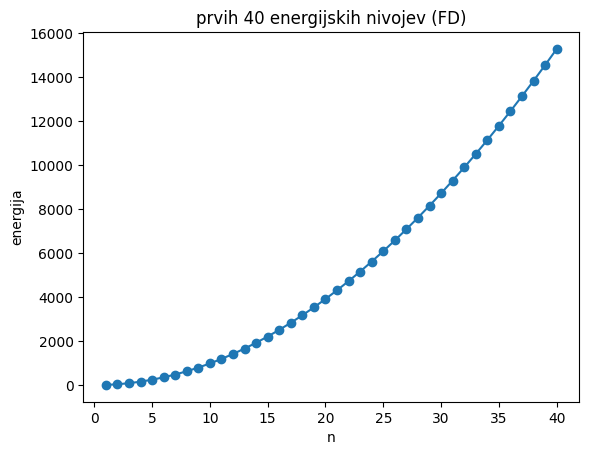

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.integrate import solve_ivp
from scipy.optimize import brentq
import time

L = 1.0

def analytic_energy(n):
    return (n * np.pi / L)**2


def analytic_wave(n, x):
    return np.sqrt(2/L) * np.sin(n * np.pi * x / L)


def solve_fd(N, num_states=40):
    x = np.linspace(0, L, N+2)
    h = x[1] - x[0]
    M = N
    diag = 2.0 / h**2 * np.ones(M)
    offdiag = -1.0 / h**2 * np.ones(M-1)
    energies, psi_mat = eigh_tridiagonal(diag, offdiag)
    energies = energies[:num_states]
    psi_mat = psi_mat[:, :num_states]
    x_int = x[1:-1]
    for i in range(num_states):
        norm = np.sqrt(np.trapz(psi_mat[:,i]**2, x_int))
        psi_mat[:,i] /= norm
    return x_int, energies, psi_mat


def shoot_wave(n, N):
    x = np.linspace(0, L, N)
    def schrodinger(xi, y, E):
        return [y[1], -E * y[0]]
    def boundary(E):
        sol = solve_ivp(lambda xi, y: schrodinger(xi, y, E), [0, L], [0.0, 1.0], t_eval=[L], method='RK45')
        return sol.y[0, -1]
    E0 = analytic_energy(n)
    a, b = E0*0.5, E0*1.5
    while boundary(a) * boundary(b) > 0:
        a *= 0.5; b *= 1.5
    E_n = brentq(boundary, a, b)
    sol = solve_ivp(lambda xi, y: schrodinger(xi, y, E_n), [0, L], [0.0, 1.0], t_eval=x, method='RK45')
    psi = sol.y[0]
    psi /= np.sqrt(np.trapz(psi**2, x))
    return x, E_n, psi


if __name__ == '__main__':
    x_fd, E_fd, psi_fd = solve_fd(200, num_states=40)
    x_fd4, E_fd4, psi_fd4 = solve_fd(200, num_states=4)
    shoot_results = [shoot_wave(n, 1000) for n in range(1,5)]
    x_sh = shoot_results[0][0]
    E_sh = np.array([res[1] for res in shoot_results])
    psi_sh = np.column_stack([res[2] for res in shoot_results])
    x_an = np.linspace(0, L, 1000)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for n in range(1, 5):
        axs[0].plot(x_an, analytic_wave(n, x_an), label=f'n={n}')
    axs[0].set_title('Analytic')
    axs[0].legend()
    for i in range(4):
        axs[1].plot(x_fd4, psi_fd4[:,i], label=f'n={i+1}')
    axs[1].set_title('Finite Difference')
    axs[1].legend()
    for i in range(4):
        axs[2].plot(x_sh, psi_sh[:,i], label=f'n={i+1}')
    axs[2].set_title('Shooting')
    axs[2].legend()
    for ax in axs:
        ax.set_xlabel('x'); ax.set_ylabel('$\psi(x)$')
    plt.tight_layout()
    plt.savefig('psi_fd_sh.png')
    plt.show()

    psi1_an_fd = analytic_wave(1, x_fd)
    psi1_fd = psi_fd[:,0]
    abs_err_fd = np.abs(psi1_fd - psi1_an_fd)
    rel_err_fd = abs_err_fd / np.abs(psi1_an_fd)
    log_err_fd = np.log(abs_err_fd)

    psi1_an_sh = analytic_wave(1, x_sh)
    psi1_sh = psi_sh[:,0]
    abs_err_sh = np.abs(psi1_sh - psi1_an_sh)
    rel_err_sh = abs_err_sh / np.abs(psi1_an_sh)
    log_err_sh = np.log(abs_err_sh)

    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    axs[0].plot(x_fd, abs_err_fd, 'g', label='FD'); axs[0].plot(x_sh, abs_err_sh, 'r', label='Shoot')
    axs[0].set_title('Absolutna napaka (n=1)'); axs[0].legend()
    axs[1].plot(x_fd, rel_err_fd, 'g', label='FD'); axs[1].plot(x_sh, rel_err_sh, 'r', label='Shoot')
    axs[1].set_title('Relativna napaka (n=1)'); axs[1].legend()
    axs[2].plot(x_fd, log_err_fd, 'g', label='FD'); axs[2].plot(x_sh, log_err_sh, 'r', label='Shoot')
    axs[2].set_title('Log(absolutna) (n=1)'); axs[2].legend()
    for ax in axs: ax.set_xlabel('x')
    plt.tight_layout()
    plt.savefig('napake.png')
    plt.show()

    Ns = [100, 250, 500, 1000]
    times_fd = []
    times_sh = []
    for N in Ns:
        t0 = time.time(); solve_fd(N, num_states=1); times_fd.append(time.time()-t0)
        t0 = time.time(); shoot_wave(1, 500); times_sh.append(time.time()-t0)
    plt.figure()
    plt.plot(Ns, times_fd, '-o', label='FD'); plt.plot(Ns, times_sh, '-o', label='Shoot')
    plt.xlabel('N'); plt.ylabel('čas [s]'); plt.title('Časovna zahtevnost'); plt.legend()
    plt.savefig('casovna_zahtevnost.png')
    plt.show()

    plt.figure()
    plt.plot(np.arange(1,41), E_fd[:40], 'o-')
    plt.xlabel('n'); plt.ylabel('energija'); plt.title('prvih 40 energijskih nivojev (FD)')
    plt.savefig('energije_fd.png')
    plt.show()

C:\Users\Gašper Harej\AppData\Local\Temp\ipykernel_3036\1337166122.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm = np.sqrt(np.trapz(psi_mat[:,i]**2, x_int))


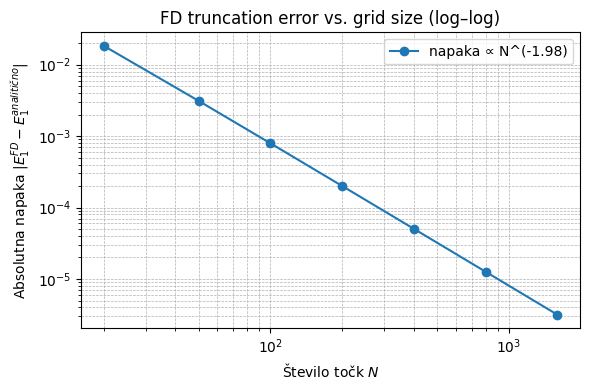

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal

L = 1.0

def analytic_energy(n):
    return (n * np.pi / L)**2

def solve_fd(N, num_states=1):
    x = np.linspace(0, L, N+2)
    h = x[1] - x[0]
    M = N
    diag    = 2.0 / h**2 * np.ones(M)
    offdiag = -1.0 / h**2 * np.ones(M-1)
    energies, psi_mat = eigh_tridiagonal(diag, offdiag)

    energies = energies[:num_states]
    psi_mat  = psi_mat[:, :num_states]

    x_int = x[1:-1]
    for i in range(num_states):
        norm = np.sqrt(np.trapz(psi_mat[:,i]**2, x_int))
        psi_mat[:,i] /= norm
    return x_int, energies, psi_mat

E1_exact = analytic_energy(1)
Ns = np.array([20, 50, 100, 200, 400, 800, 1600])
errors = []

for N in Ns:
    _, E_fd, _ = solve_fd(N, num_states=1)
    err = np.abs(E_fd[0] - E1_exact)
    errors.append(err)

errors = np.array(errors)

coeffs = np.polyfit(np.log(Ns), np.log(errors), 1)
slope = coeffs[0]

plt.figure(figsize=(6,4))
plt.loglog(Ns, errors, 'o-', label=f'napaka ∝ N^({slope:.2f})')
plt.xlabel('Število točk $N$')
plt.ylabel(r'Absolutna napaka $|E_1^{FD}-E_1^{analitično}|$')
plt.title('FD truncation error vs. grid size (log–log)')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('fd_error_vs_N.png')
plt.show()

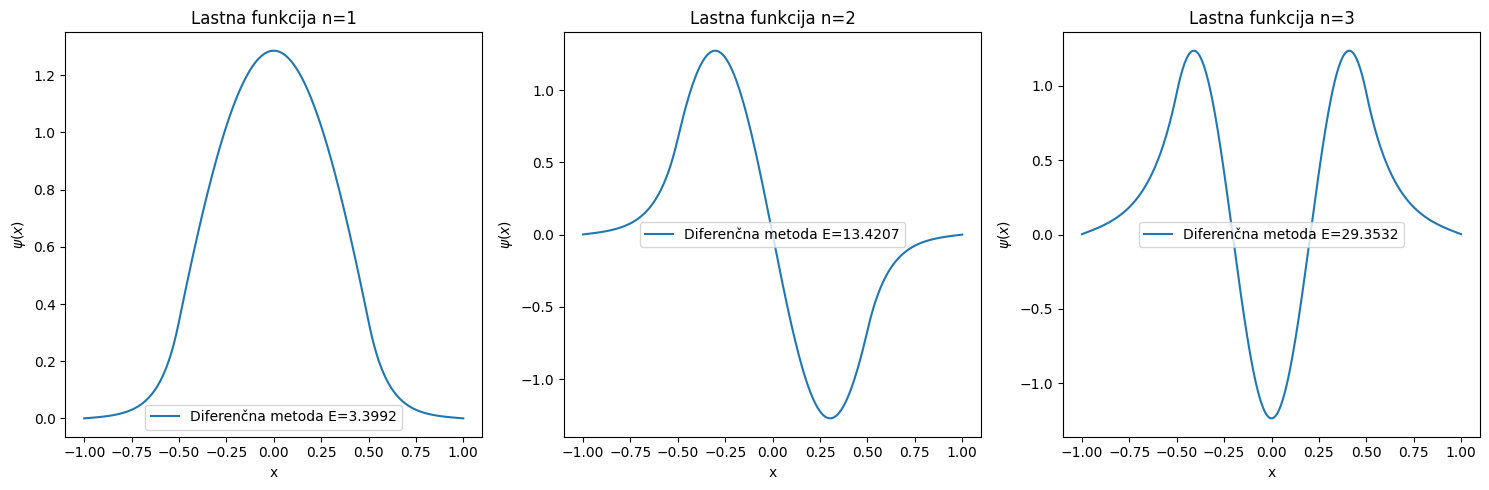

C:\Users\Gašper Harej\AppData\Local\Temp\ipykernel_3036\490866333.py:62: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi_norm = sol.y[0]/np.sqrt(np.trapz(sol.y[0]**2, sol.t))


Diferenčna metoda energije: [ 3.39918977 13.4207134  29.35323659]
Strelska metoda energije: [12.525608942835074, 12.525608942837104, 135.76787912036653]


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.integrate import solve_ivp
from scipy.optimize import brentq

a = 1.0                
V0 = 50.0             
N = 400         

x = np.linspace(-a, a, N)
h = x[1] - x[0]

V = np.zeros(N)
V[np.abs(x) >= a/2] = V0

diag = 1/h**2 + V
offdiag = np.full(N-1, -0.5/h**2)

E_num, psi_num = eigh_tridiagonal(diag, offdiag)

E_num = E_num[:3]
psi_num = psi_num[:, :3]

psi_num /= np.sqrt(h)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].plot(x, psi_num[:, i], label=f"Diferenčna metoda E={E_num[i]:.4f}")
    axes[i].set_title(f'Lastna funkcija n={i+1}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('$\\psi(x)$')
    axes[i].legend()

plt.tight_layout()
plt.savefig('dodatna_naloga.png')
plt.show()

def schrodinger(x, y, E):
    return [y[1], (V0 if abs(x) >= a/2 else 0 - 2*E)*y[0]]

E_strel = []
psi_strel = []

for n in range(1, 4):
    E_guess = E_num[n-1]

    def boundary(E):
        sol = solve_ivp(schrodinger, [0, a], [0, 1], args=(E,), t_eval=[a])
        return sol.y[0][-1]

    E_min, E_max = E_guess * 0.5, E_guess * 1.5
    while boundary(E_min) * boundary(E_max) > 0:
        E_min *= 0.5
        E_max *= 1.5

    E_n = brentq(boundary, E_min, E_max)
    sol = solve_ivp(schrodinger, [0, a], [0, 1], args=(E_n,), t_eval=np.linspace(0,a,N))

    E_strel.append(E_n)
    psi_norm = sol.y[0]/np.sqrt(np.trapz(sol.y[0]**2, sol.t))
    psi_strel.append(psi_norm)

print("Diferenčna metoda energije:", E_num)
print("Strelska metoda energije:", E_strel)
